# Stacking
#### Alan Kessler


## Background

I came across a paper from SAS, [Stacked Ensemble Models for Improved Prediction Accuracy](http://support.sas.com/resources/papers/proceedings17/SAS0437-2017.pdf), that seemed interesting. Lacking SAS Viya, I attempt to try other methods of generating strong predictions using Python and **h2o** using the same data.

In [1]:
"""Recreate a stacking example using H2O."""

import pandas as pd
from pandas.api.types import is_string_dtype
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn import metrics
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.naive_bayes import H2ONaiveBayesEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from h2o.automl import H2OAutoML
from h2o.grid.grid_search import H2OGridSearch

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_151"; Java(TM) SE Runtime Environment (build 1.8.0_151-b12); Java HotSpot(TM) 64-Bit Server VM (build 25.151-b12, mixed mode)
  Starting server from /Users/alankessler/.local/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/d5/9wnj9njn45xfkqxg5wjzyv0c0000gn/T/tmp0kh_js4e
  JVM stdout: /var/folders/d5/9wnj9njn45xfkqxg5wjzyv0c0000gn/T/tmp0kh_js4e/h2o_alankessler_started_from_python.out
  JVM stderr: /var/folders/d5/9wnj9njn45xfkqxg5wjzyv0c0000gn/T/tmp0kh_js4e/h2o_alankessler_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.3
H2O cluster version age:,8 days
H2O cluster name:,H2O_from_python_alankessler_8bvgnd
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


## Data

### Load Data

Like in the SAS paper, the data is from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Adult). The goal is to determine, using census data, if income exceeds $50K/yr.

I first download both the training and testing data. Next, I create a separate variable for the numeric target and drop **`income`** as a result. I am also not considering `education` due to the precense of **`education_num`**. Adding **`id`** as some of the transformations change the order and index of the data, making checks for reasonableness more difficult.

In [2]:
def load_data(partition="data"):
    """Load data and create targetself.

    Args:
        - partition: whether to use the training ("data") or testing ("test").

    Returns:
        a pandas DataFrame containing the testing or training data.

    """
    url = ("http://archive.ics.uci.edu/ml/"
           "machine-learning-databases/adult/adult.")

    names = ["age", "workclass", "fnlwgt", "education", "education.num",
             "marital.status", "occupation", "relationship", "race", "sex",
             "capital.gain", "capital.loss", "hours.per.week",
             "native.country", "income"]
    # Download from the correct directory based on partition
    if partition == "data":
        income_data = pd.read_csv(url+"data", names=names)
        # Create binary target
        income_data['target'] = np.where(income_data['income'] == " <=50K",
                                         1, 0)
    else:
        income_data = pd.read_csv(url+"test", names=names, skiprows=1)
        # Create binary target
        income_data['target'] = np.where(income_data['income'] == " <=50K.",
                                         1, 0)

    # Drop income after creating target and remove education as duplicative
    income_data.drop(['education', 'income'], axis=1, inplace=True)
    # Create fixed id for reference
    income_data['id'] = range(1, income_data.shape[0]+1)

    return income_data


data = load_data()
test = load_data(partition="test")

### Group Nominal Variables

Some of the nominal variables are relatively rare and warrant grouping to reduce cardinality. As in the SAS paper, I identify levels with less than 2% of training observations. 

In [3]:
def univar_freq(dataset):
    """Print categorical frequencies and mean target results."""
    # Loop through all categorical variables
    for columns in dataset:
        if is_string_dtype(data[columns]):
            # Calculate summary statistics for the variable and the target
            catgy = dataset[[columns,
                             'target']].groupby(columns).agg([len, np.mean])
            catgy.columns = catgy.columns.droplevel()
            # Calculate the percentage of observations in each category
            catgy['Percent'] = np.round(100 * catgy['len'] / sum(catgy['len']),
                                        2)
            # Format the output to display in the notebook
            catgy['Target'] = np.round(catgy['mean'], 2)
            catgy.columns = ['Count', 'mean', 'Percent', 'Target']
            display(catgy[['Count', 'Percent',
                           'Target']].sort_values(by=['Count'],
                                                  ascending=False))
        else:
            pass


univar_freq(data)

,Count,Percent,Target
workclass,,,
Private,22696,69.70,0.78
Self-emp-not-inc,2541,7.80,0.72
Local-gov,2093,6.43,0.71
?,1836,5.64,0.90
State-gov,1298,3.99,0.73
Self-emp-inc,1116,3.43,0.44
Federal-gov,960,2.95,0.61
Without-pay,14,0.04,1.00
Never-worked,7,0.02,1.00


,Count,Percent,Target
marital.status,,,
Married-civ-spouse,14976,45.99,0.55
Never-married,10683,32.81,0.95
Divorced,4443,13.65,0.90
Separated,1025,3.15,0.94
Widowed,993,3.05,0.91
Married-spouse-absent,418,1.28,0.92
Married-AF-spouse,23,0.07,0.57


,Count,Percent,Target
occupation,,,
Prof-specialty,4140,12.71,0.55
Craft-repair,4099,12.59,0.77
Exec-managerial,4066,12.49,0.52
Adm-clerical,3770,11.58,0.87
Sales,3650,11.21,0.73
Other-service,3295,10.12,0.96
Machine-op-inspct,2002,6.15,0.88
?,1843,5.66,0.90
Transport-moving,1597,4.90,0.80


,Count,Percent,Target
relationship,,,
Husband,13193,40.52,0.55
Not-in-family,8305,25.51,0.90
Own-child,5068,15.56,0.99
Unmarried,3446,10.58,0.94
Wife,1568,4.82,0.52
Other-relative,981,3.01,0.96


,Count,Percent,Target
race,,,
White,27816,85.43,0.74
Black,3124,9.59,0.88
Asian-Pac-Islander,1039,3.19,0.73
Amer-Indian-Eskimo,311,0.96,0.88
Other,271,0.83,0.91


,Count,Percent,Target
sex,,,
Male,21790,66.92,0.69
Female,10771,33.08,0.89


,Count,Percent,Target
native.country,,,
United-States,29170,89.59,0.75
Mexico,643,1.97,0.95
?,583,1.79,0.75
Philippines,198,0.61,0.69
Germany,137,0.42,0.68
Canada,121,0.37,0.68
Puerto-Rico,114,0.35,0.89
El-Salvador,106,0.33,0.92
India,100,0.31,0.60


Based on the results, I group levels under the 2% threshold with similar levels. 

I use functions for all of these transformations to make the process reproducible for the test data.

In [4]:
def grp_workclass(row):
    """Group workclass levels based on univariate results."""
    if row['workclass'] in [" ?", " Without-pay", " Never-worked"]:
        group = "None"
    else:
        group = row['workclass']
    return group


def grp_marital_status(row):
    """Group martial status levels based on univariate results."""
    if row['marital.status'] in [" Widowed", " Married-spouse-absent"]:
        group = "Absent"
    elif row['marital.status'] in [" Married-civ-spouse",
                                   " Married-AF-spouse"]:
        group = "Married"
    else:
        group = row['marital.status']
    return group


def grp_occupation(row):
    """Group occupation levels based on univariate results."""
    if row['occupation'] in [" ?", " Armed-Forces"]:
        group = "Other"
    elif row['occupation'] in [" Protective-serv", " Tech-support"]:
        group = "Support"
    elif row['occupation'] in [" Priv-house-serv", " Other-service"]:
        group = "Other-service"
    else:
        group = row['occupation']
    return group


def grp_race(row):
    """Group race categories based on univariate results."""
    if row['race'] in [" Black", " Other", " Amer-Indian-Eskimo"]:
        group = "Other"
    else:
        group = row['race']
    return group


def grp_native_country(row):
    """Group native country categories based on univariate results."""
    if row['native.country'] not in [" United-States"]:
        group = "Other"
    else:
        group = row['native.country']
    return group


def grp_categories(raw_data):
    """Apply grouping functions to return a grouped version of the data."""
    grpd = raw_data.copy()
    grpd['workclass'] = grpd.apply(grp_workclass, axis=1)
    grpd['marital.status'] = grpd.apply(grp_marital_status, axis=1)
    grpd['occupation'] = grpd.apply(grp_occupation, axis=1)
    grpd['race'] = grpd.apply(grp_race, axis=1)
    grpd['native.country'] = grpd.apply(grp_native_country, axis=1)
    return grpd


data_grpd = grp_categories(data)

### Likelihood Encode Nominal Variables

After grouping, the nominal variables are likelihood encoded matching the original paper. 

This encoding causes information leakage if using the target from the entire training data and then performing cross-validation. Leakage is minimized if cardinality is small and the target is not rare which is true in part due to the grouping I did previously. Otherwise, I would need to do the encoding in each of the cross-validation folds which would be fairly complicated.   

In [5]:
def likelihood_encode(raw_data):
    """Likelihood encode grouped categorical varaibles."""
    encd = raw_data.copy()
    for columns in raw_data:
        if is_string_dtype(raw_data[columns]):
            woe = raw_data[[columns, 'target']].groupby(columns).agg([np.mean])
            woe.columns = woe.columns.droplevel()
            woe.columns = ["enc."+columns]
            encd = encd.merge(woe.reset_index())
            encd.drop([columns], axis=1, inplace=True)
        else:
            pass
    return encd.sort_values(by=['id'])


data_enc = likelihood_encode(data_grpd)
test_enc = likelihood_encode(grp_categories(test.sort_values(by=['id'])))

## h2o Models

I test several types of models including automatic machine learning and stacking. Models chosen in grid searches are determined by mean-squared-error, the metric used in the paper. For stacking, I choose to keep cross validation predictions, use the "Modulo" fold assignment method, and specify the same number of folds and random number seed for all models.

### Data

Python is just an interface to the H2O JVM, so removing objects can avoid errors if the object already exists. I create an H2OFrame from the modified pandas dataframe and specify that **`target`** is a factor. 

In [6]:
# Remove the object if it exists and load into H2O
h2o.remove('data_h2o')
data_h2o = h2o.H2OFrame(data_enc)
data_h2o['target'] = data_h2o['target'].asfactor()

h2o.remove('test_h2o')
test_h2o = h2o.H2OFrame(test_enc)
test_h2o['target'] = test_h2o['target'].asfactor()

predictors = [i for i in data_h2o.columns if i not in ['target', 'id']]

def grid_training(algorithm, hyp_params, name, **params):
    """Train model on a grid for this specific data.

    Args:
        - algorithm (H2O Function) - H2O algorithm to train.
        - hyp_params (dict) - Dictionary of hyper-parameters.
        - name (string) - A key that identifies this grid search object in H2O.
        - **params - Any algorithm-specific parameters needed in training.

    Returns:
        - H2O model object of the best fitting model in the grid.
        - H2O performance metrics on the test data for the model.
    """
    # Remove model object
    h2o.remove('model_grid')

    # Specify the model
    model_grid = H2OGridSearch(model=algorithm,
                               grid_id=name+'_grid',
                               hyper_params=hyp_params)

    # Train on the grid
    model_grid.train(x=predictors, y='target', training_frame=data_h2o,
                     nfolds=5, seed=98, fold_assignment='Modulo',
                     keep_cross_validation_predictions=True, **params)

    # Generate a leaderboard by logloss
    model_gridperf = model_grid.get_grid(sort_by='mse', decreasing=False)

    # Generate fit statistics for the best ranking model on the test set
    best_model = model_gridperf.models[0]
    best_model_perf = best_model.model_performance(test_h2o)

    return best_model, best_model_perf

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


### Logistic Regression 

I fit a logistic regression, allowing the weight between the l1 (lasso) and l2 (ridge) penalty vary in a grid.

In [7]:
best_glm, best_glm_perf = grid_training(H2OGeneralizedLinearEstimator,
                                        {'alpha': [0, 0.25, 0.5, 0.75, 1]},
                                        'glm',
                                        **{'family': 'binomial',
                                           'lambda_search': True})

glm Grid Build progress: |████████████████████████████████████████████████| 100%


### Random Forest

I fit a random forest with a simple grid of the number of columns to select at each level.

In [8]:
best_drf, best_drf_perf = grid_training(H2ORandomForestEstimator,
                                        {'mtries': [-1, 2, 3, 5]},
                                        'drf')

drf Grid Build progress: |████████████████████████████████████████████████| 100%


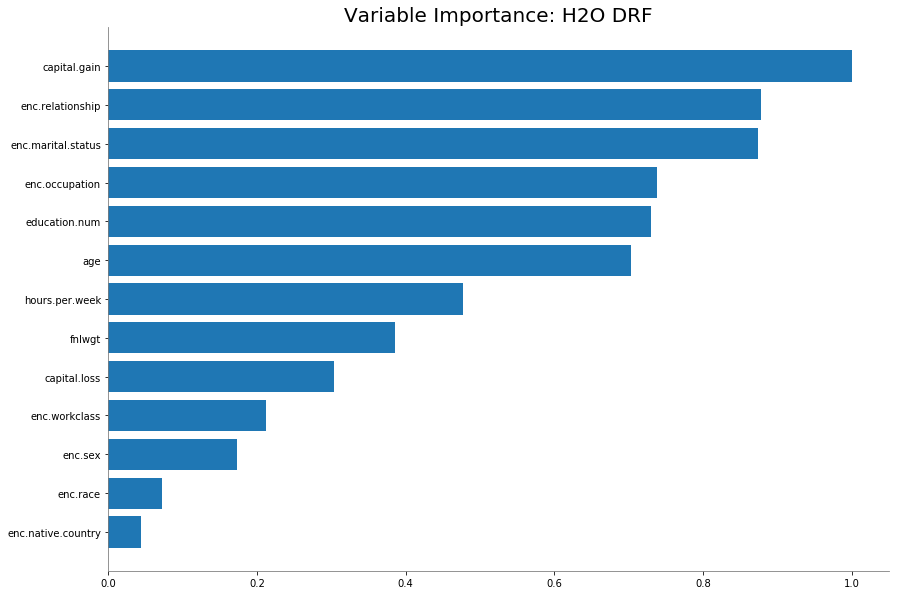

In [9]:
best_drf.varimp_plot(num_of_features=13)

### Gradient Boosting Machine

I fit a gradient boosting machine with a more complex grid requiring significantly more training time.

In [10]:
best_gbm, best_gbm_perf = grid_training(H2OGradientBoostingEstimator,
                                        {'learn_rate': [0.01, 0.1],
                                         'max_depth': [3, 5, 9],
                                         'sample_rate': [0.8, 1.0],
                                         'col_sample_rate': [0.2, 0.5, 1.0]},
                                        'gbm',
                                        **{'distribution': 'bernoulli'})

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


### Naive Bayes Classifier

I fit a Naive Bayes Classifier without any hyperparameter tuning.

In [11]:
# Train model
h2o.remove('nb_model')
nb_model = H2ONaiveBayesEstimator(nfolds=5, seed=98, model_id='nb_model',
                                  fold_assignment='Modulo',
                                  keep_cross_validation_predictions=True)

nb_model.train(x=predictors, y='target', training_frame=data_h2o)

# Generate fit statistics for the best ranking model on the test set
nb_model_perf = nb_model.model_performance(test_h2o)

naivebayes Model Build progress: |████████████████████████████████████████| 100%


### AutoML

I use the built-in automatic machine learning process to generate a series of models. Since stacked ensembles are part of the process, it will not be incorporated into the stacked ensemble.

In [12]:
# Run AutoML for four minutes
aml = H2OAutoML(max_runtime_secs=240)

aml.train(x=predictors, y='target', training_frame=data_h2o)

# Generate fit statistics for the best ranking model on the test set
best_aml_perf = aml.leader.model_performance(test_h2o)

aml.leaderboard

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
XGBoost_1_AutoML_20181230_071921,0.926994,0.280932,0.205501,0.2985,0.0891024
StackedEnsemble_AllModels_AutoML_20181230_071921,0.926928,0.295746,0.202771,0.302028,0.0912211
StackedEnsemble_BestOfFamily_AutoML_20181230_071921,0.926753,0.295832,0.204181,0.302114,0.091273
XGBoost_2_AutoML_20181230_071921,0.925716,0.283019,0.22097,0.299642,0.0897855
XRT_1_AutoML_20181230_071921,0.915543,0.314545,0.219874,0.308793,0.0953529
DRF_1_AutoML_20181230_071921,0.913796,0.335504,0.225516,0.309536,0.0958125
GLM_grid_1_AutoML_20181230_071921_model_1,0.902075,0.326344,0.269023,0.323206,0.104462


### Fit Statistics of First Level Models

In [13]:
# Generate tables of fit statistics
mse = pd.DataFrame({'Model': ['Logistic', 'Random Forest', 'GBM',
                              'Naive Bayes', 'AutoML'],
                    'CV MSE': [best_glm.mse(xval=True),
                               best_drf.mse(xval=True),
                               best_gbm.mse(xval=True),
                               nb_model.mse(xval=True),
                               aml.leader.mse(xval=True)],
                    'Test MSE': [best_glm_perf.mse(),
                                 best_drf_perf.mse(),
                                 best_gbm_perf.mse(),
                                 nb_model_perf.mse(),
                                 best_aml_perf.mse()]}).set_index('Model')
mse['CV MSE'] = pd.Series([f"{val:.5f}" for val in mse['CV MSE']],
                          index=mse.index)
mse['Test MSE'] = pd.Series([f"{val:.5f}" for val in mse['Test MSE']],
                            index=mse.index)

auc = pd.DataFrame({'Model': ['Logistic', 'Random Forest', 'GBM',
                              'Naive Bayes', 'AutoML'],
                    'CV AUC': [best_glm.auc(xval=True),
                               best_drf.auc(xval=True),
                               best_gbm.auc(xval=True),
                               nb_model.auc(xval=True),
                               aml.leader.auc(xval=True)],
                    'Test AUC': [best_glm_perf.auc(),
                                 best_drf_perf.auc(),
                                 best_gbm_perf.auc(),
                                 nb_model_perf.auc(),
                                 best_aml_perf.auc()]}).set_index('Model')
auc['CV AUC'] = pd.Series([f"{val:.5f}" for val in auc['CV AUC']],
                          index=auc.index)
auc['Test AUC'] = pd.Series([f"{val:.5f}" for val in auc['Test AUC']],
                            index=auc.index)

display(mse)
display(auc)

,CV MSE,Test MSE
Model,,
Logistic,0.10446,0.10367
Random Forest,0.09467,0.09484
GBM,0.08897,0.08923
Naive Bayes,0.14172,0.14280
AutoML,0.08910,0.08955


,CV AUC,Test AUC
Model,,
Logistic,0.90207,0.90282
Random Forest,0.91756,0.91592
GBM,0.92701,0.92556
Naive Bayes,0.86168,0.85971
AutoML,0.92699,0.92523


### Stacked Ensemble 

I fit a simple stacked ensemble using a linear model. 

In [14]:
# Train a stacked ensemble
h2o.remove('ensemble')
ensemble = H2OStackedEnsembleEstimator(model_id='ensemble',
                                       base_models=[best_glm, best_drf,
                                                    best_gbm, nb_model])

ensemble.train(x=predictors, y='target', training_frame=data_h2o)

# Generate fit statistics for the best ranking model on the test set
ensemble_perf = ensemble.model_performance(test_h2o)

stackedensemble Model Build progress: |███████████████████████████████████| 100%


### Fit Statistics for All Models

In [15]:
# Generate table of fit statistics on test data
fit = pd.DataFrame({'Model': ['Logistic', 'Random Forest', 'GBM',
                              'Naive Bayes', 'AutoML', 'Ensemble'],
                    'Test MSE': [best_glm_perf.mse(), best_drf_perf.mse(),
                                 best_gbm_perf.mse(), nb_model_perf.mse(),
                                 best_aml_perf.mse(), ensemble_perf.mse()],
                    'Test AUC': [best_glm_perf.auc(), best_drf_perf.auc(),
                                 best_gbm_perf.auc(), nb_model_perf.auc(),
                                 best_aml_perf.auc(),
                                 ensemble_perf.auc()]}).set_index('Model')
fit['Test MSE'] = pd.Series([f"{val:.5f}" for val in fit['Test MSE']],
                            index=fit.index)
fit['Test AUC'] = pd.Series([f"{val:.5f}" for val in fit['Test AUC']],
                            index=fit.index)

display(fit)

,Test MSE,Test AUC
Model,,
Logistic,0.10367,0.90282
Random Forest,0.09484,0.91592
GBM,0.08923,0.92556
Naive Bayes,0.14280,0.85971
AutoML,0.08955,0.92523
Ensemble,0.09215,0.92484


## Visual Comparison of Top Models

The fit statistics show that the tuned GBM and the AutoML fit the test data very well. The simplicity of the logistic regression also makes it an interesting candidate. I use two different plots to compare the models more closely. 

### Lift

Plotting the testing target rate by prediction decile.

In [16]:
def score_bin(model, label):
    """Aggregate performance data for lift charts."""
    test_lift = test_enc.copy()
    score = model.predict(test_h2o).as_data_frame()
    test_lift['bin'] = np.array(pd.qcut(score['p1'], q=10, labels=list(range(1, 11))))
    test_lift = test_lift[['bin', 'target']].groupby(['bin']).agg([np.mean])
    test_lift.columns = test_lift.columns.droplevel()
    test_lift.columns = [label]
    return test_lift


lift = pd.concat([score_bin(best_glm, "Logistic"),
                  score_bin(best_gbm, "GBM"),
                  score_bin(aml.leader, "AutoML")],
                 axis=1)

lift = pd.melt(lift.reset_index(), id_vars=['bin'])
lift.columns = ['bin', 'Model', 'value']

glm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%


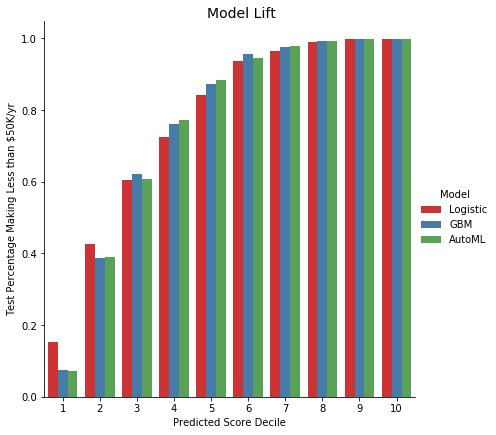

In [21]:
# Plot lift
lift_plt = sns.catplot(x='bin', y='value', hue='Model', data=lift,
                       height=6, kind='bar', palette='Set1')

lift_plt.set_ylabels("Test Percentage Making Less than $50K/yr")
lift_plt.set_xlabels("Predicted Score Decile")
lift_plt.fig.suptitle("Model Lift", fontsize=14, y=1)
plt.show()

### Dual Lift Model Comparison

The lift chart shows that the AutoML and GBM results are very close. The dual lift model comparison plots the test target and the model predictions by the decile difference in the two models. The result shows that the AutoML ensemble fits the test data well.

In [18]:
score_diff = test_enc.copy()
score_gbm = best_gbm.predict(test_h2o).as_data_frame()
score_aml = aml.leader.predict(test_h2o).as_data_frame()
score_diff['gbm'] = np.array(score_gbm['p1'])
score_diff['aml'] = np.array(score_aml['p1'])
score_diff['diff'] = score_diff['aml'] - score_diff['gbm']
score_diff['diff_bin'] = pd.qcut(score_diff['diff'], q=10, labels=list(range(1,11)))

score_diff_agg = score_diff[['diff_bin', 'target', 'gbm', 'aml']].groupby(['diff_bin']).agg([np.mean])
score_diff_agg.columns = score_diff_agg.columns.droplevel()
score_diff_agg.columns = ['Actual', 'GBM', 'AutoML']
score_diff_agg = pd.melt(score_diff_agg.reset_index(), id_vars=['diff_bin'])
score_diff_agg.columns = ['Difference Bin', 'Model', 'Predicted Probability']


gbm prediction progress: |████████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%


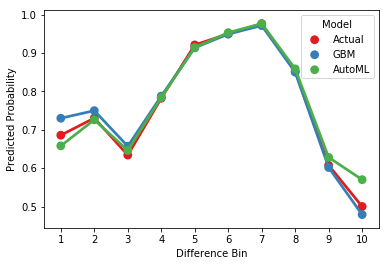

In [19]:
dlift_plt = sns.pointplot(x="Difference Bin", y="Predicted Probability", hue="Model", 
                          palette="Set1", data=score_diff_agg, markers=["o", "o", "o"])
plt.show()